In [1]:
import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import wbdata

from descartes import PolygonPatch
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path

In [2]:
#Importamos el dataset
gfi = pd.read_csv(r'C:\Users\wdi_w\Desktop\W\UTN\Poster\micro_world.csv') 

#Importamos las preguntas del cuestionario
quest = pd.read_csv(r'C:\Users\wdi_w\Desktop\W\UTN\Poster\Cuestionario.csv', delimiter=";")
questd= dict(zip(quest.id,quest.Variable)) #Convertimos el cuestionario en diccionario

#Importamos un mapamundi para utilizar con GeoPandas
mapamundi=gpd.GeoDataFrame.from_file(r'C:\Users\wdi_w\Desktop\W\UTN\Poster\World_Countries/World_Countries.shp')

#observamos el temaño de la base
print(f'Shape: {np.shape(gfi)}')


Shape: (154923, 105)


In [3]:
#Quitamos los duplicados
gfi.drop_duplicates(inplace=True, keep='first')
total = gfi.isnull().sum().sort_values(ascending=False)
porcentaje = (gfi.isnull().sum()/gfi.isnull().count()).sort_values(ascending=False)
data_faltante = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
gfif = gfi.drop((data_faltante[data_faltante['Porcentaje'] > 0.5]).index,1) # eliminamos las columnas con mas de 15% de Nulos
gfi_quest=gfif.iloc[:,11:] #Creamos un subset con los datos que tienen formato cuestionario
gfi_inx=gfif.iloc[:,0:1] #Creamos un subset con los paises 
gfi_inx2=gfif.iloc[:,2:3] #Creamos un subset con las regiones
gfi_datos=gfif.iloc[:,0:11] #Creamos un subset que incluye dichos indices y los datos que no son en formato cuestionario
paises=gfi['economy'].unique() # Tomamos los valores unicos de pais 
paises_c=gfi['economycode'].unique() #Hacemos lo mismo con el codigo de pais
region=gfi['regionwb'].unique() # Tomamos los valores unicos de region
gfi_pais=pd.DataFrame() #Creamos un DF vacio
gfi_region=pd.DataFrame() #Creamos un DF vacio
imputer = IterativeImputer(missing_values = np.nan, initial_strategy = 'most_frequent', max_iter=3, random_state=0)
imputer = imputer.fit(gfi_quest)
gfi_quest2= (pd.DataFrame(imputer.transform(gfi_quest)))
gfi_quest2.columns=gfi_quest.columns
#se redondean las imputaciones para obtener valores enteros como son las respuestas del cuestionario
gfi_quest2=gfi_quest2.round(0)
gfi_quest4=gfi_quest2.replace([2, 3, 4], 0)
gfi_f3=gfi_datos.join(gfi_quest4)
gfi_f3=gfi_f3.dropna()

In [4]:
#Generamos dummies por region
dummies = pd.get_dummies(gfi_f3.regionwb)
gfi_f3=gfi_f3.join(dummies, how='left')
print(gfi_f3.shape)


(152466, 63)


In [5]:
#Dividimos el dataset entre Train y Test

y = np.array(gfi_f3[["fin22a"]])
x = gfi_f3.drop(['economy','economycode','regionwb',"borrowed","fin22a","fin19"], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.80, random_state=42)
scaler = preprocessing.StandardScaler().fit(xtrain)
xtrain_scal = scaler.transform(xtrain) 
xtest_scal = scaler.transform(xtest) 

In [6]:
#Nos quedamos con las variables con mayor poder explicativo para reducir la dimensionalidad utilizando LASSO
lasso_featsel = Lasso(alpha = 0.01)
lasso_featsel.fit(xtrain_scal,ytrain)
eps = 5e-3
alphas_lasso, coefs_lasso, _ = lasso_path(xtrain_scal, ytrain, fit_intercept=False)
lasso_feat_cols = lasso_featsel.coef_ != 0

xtrain_scal_red_lasso = xtrain_scal[:, lasso_feat_cols]
np.shape(xtrain_scal_red_lasso)
xtest_scal_red_lasso = xtest_scal[:, lasso_feat_cols]
np.shape(xtest_scal_red_lasso)

(121973, 20)

In [7]:
# Vemos con que columnas nos quedamos despues de seleccionar con el Lasso
x.iloc[:, lasso_feat_cols].rename(columns=questd).columns

Index(['pop_adult', 'Respondent is in the workforce', 'Has a debit card',
       'Used mobile phone or internet to check account balance',
       'Has a credit card',
       'If has account: any withdrawal from account in past 12 months',
       'Made bill payments online using the Internet',
       'Saved in past 12 months: using an account at a financial institution',
       'Borrowed in past 12 months: for medical purposes',
       'Borrowed in past 12 months: for farm/business purposes',
       'Sent domestic remittances in past 12 months',
       'Paid utility bills in past 12 months',
       'If paid utility bills: using an account',
       'If paid utility bills: through a mobile phone',
       'Received wage payments in past 12 months',
       'Received self-employment payments: in past 12 months',
       'Has an account at a financial institution', 'Payments: wage payments',
       'East Asia & Pacific (excluding high income)',
       'Sub-Saharan Africa (excluding high income

In [8]:
#Vemos el tamaño del set
print("Shape: " +str(np.shape(xtrain_scal_red_lasso)))

Shape: (30493, 20)


In [9]:
#Corremos un svm. Por lo grande del set (la matriz), se probaron distintores valores de costos y...
#gammas por partes y se dejaron los que mejor performance tenian
parameters = {'kernel':['rbf'], 'C':[1], 'gamma':[0.001, 0.01]}
svc = svm.SVC(cache_size=9000)
svmm = GridSearchCV(svc, param_grid = parameters, refit = True, cv =3 )
#cv indica la cantidad de folds
#refit nos permite ajustar la muestra al final con los mejores parametros encontrados 
svmm.fit(xtrain_scal_red_lasso, ytrain.ravel())
print("The best parameters are %s with a score of %0.2f" % (svmm.best_params_, svmm.best_score_))

The best parameters are {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} with a score of 0.89


In [10]:
#Corremos un modelo KNN
parametersk= {"n_neighbors":[1, 10, 100] }
knn=KNeighborsClassifier()
knnm = GridSearchCV(knn, param_grid = parametersk, refit = True, cv = 5)
knnm.fit(xtrain_scal_red_lasso, ytrain.ravel())
print("The best parameters are %s with a score of %0.2f" % (knnm.best_params_, knnm.best_score_))

The best parameters are {'n_neighbors': 100} with a score of 0.88


In [11]:
#Corremos un modelo de regresion logistica
lr = LogisticRegression(random_state=0, solver='lbfgs')
lr.fit(xtrain_scal_red_lasso, ytrain.ravel())
print("The score is %0.2f" % (lr.score(xtrain_scal_red_lasso, ytrain.ravel())))

The score is 0.88


In [12]:
#Generamos las predicciones
y_pred_svm=svmm.predict(xtest_scal_red_lasso) 
y_pred_knn=knnm.predict(xtest_scal_red_lasso) 
y_pred_lr=lr.predict(xtest_scal_red_lasso)

In [13]:
#Comparamos las regresiones con el test y comparamos las medidas de error

print('RSME RL :'+ str(np.sqrt(mean_squared_error(ytest, y_pred_lr))))
print('RSME KNN:'+ str(np.sqrt(mean_squared_error(ytest, y_pred_knn))))
print('RSME SVM:'+ str(np.sqrt(mean_squared_error(ytest, y_pred_svm))))
print('------------------------')
print('MSE RL :'+str( mean_squared_error(ytest, y_pred_lr)))
print('MSE KNN:'+str( mean_squared_error(ytest, y_pred_knn)))
print('MSE SVM:'+str( mean_squared_error(ytest, y_pred_svm)))
print('------------------------')
print('MAE RL :'+str(mean_absolute_error(ytest, y_pred_lr)))
print('MAE KNN:'+str(mean_absolute_error(ytest, y_pred_knn)))
print('MAE SVM:'+str(mean_absolute_error(ytest, y_pred_svm)))
print('------------------------')
print("Accuracy RL : " + str(accuracy_score(ytest, y_pred_lr)))
print("Accuracy KNN: " + str(accuracy_score(ytest, y_pred_knn)))
print("Accuracy SVM: " + str(accuracy_score(ytest, y_pred_svm)))

RSME RL :0.3388638245603697
RSME KNN:0.3369470625313736
RSME SVM:0.33575268643132666
------------------------
MSE RL :0.11482869159568102
MSE KNN:0.11353332294852139
MSE SVM:0.11272986644585277
------------------------
MAE RL :0.11482869159568102
MAE KNN:0.11353332294852139
MAE SVM:0.11272986644585277
------------------------
Accuracy RL : 0.885171308404319
Accuracy KNN: 0.8864666770514786
Accuracy SVM: 0.8872701335541472


In [14]:
 #AUC ROC del KNN
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

yproba = knnm.predict_proba(xtest_scal_red_lasso)
yproba2 = lr.predict_proba(xtest_scal_red_lasso)
fpr1, tpr1, thresholds = roc_curve(ytest.astype('int'), yproba[:,1], drop_intermediate = False)
fpr2, tpr2, thresholds2 = roc_curve(ytest.astype('int'), yproba2[:,1], drop_intermediate = False)
auc = metrics.auc(fpr1, tpr1)
auc2 = metrics.auc(fpr2, tpr2)
print("El AUC KNN es = " + str(auc))
print("El AUC LR es = " + str(auc2))

El AUC KNN es = 0.8069783526966453
El AUC LR es = 0.8088363669702257


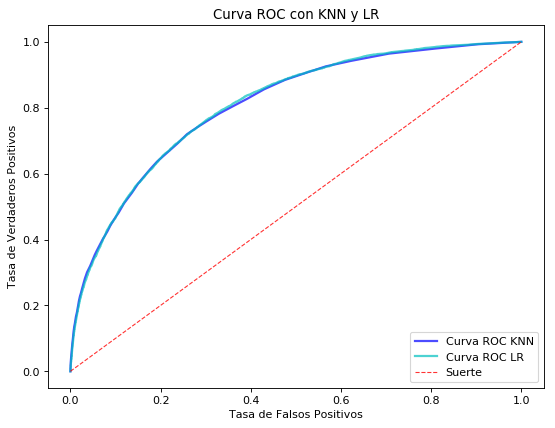

In [15]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fpr1, tpr1, lw=2, alpha=0.7 , label = 'Curva ROC KNN', color = 'b')
plt.plot(fpr2, tpr2, lw=2, alpha=0.7 , label = 'Curva ROC LR', color = 'c')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Suerte', alpha=.8)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.grid(False)

plt.legend(loc="lower right")
plt.title('Curva ROC con KNN y LR')
plt.show()

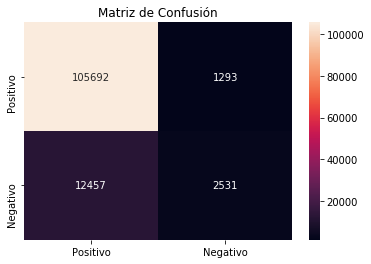

In [16]:
 #Matriz de confusion del SVM
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred_svm)

df_cm = pd.DataFrame(cm, index = ['Positivo', 'Negativo'], columns = ['Positivo', 'Negativo'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True,fmt='g')
plt.title('Matriz de Confusión')
plt.show()